## **Final Project - House Price Prediction** ##

Import required libraries:

In [118]:
import urllib.request
import bs4
from datetime import datetime
import re
import pandas as pd
from dateutil import parser
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns



### Parse the housing data webpage HTML to retrieve the data, and format in a pandas DataFrame including all relevant descriptive features: ###

In [2]:
# Attempt to fetch URL
url = "http://mlg.ucd.ie/modules/python/housing/"
try:
    response = urllib.request.urlopen(url)
    html = response.read().decode()
except:
    print("Failed to retrieve %s" % url)

# Parse HTML
soup_parser = bs4.BeautifulSoup(html,"html.parser") 

count_house=0 # track number of houses 
data1 = [] # stores formatted row for each house
for row in soup_parser.find('table').tbody.find_all('tr'):
    # Extracting all cells in  row
    cells = row.find_all('td')
    
    # Data extraction per column, commas removed for convenience
    sale_date = cells[0].text.strip().replace(',', '')
    location = cells[1].text.strip()
    price = cells[2].text.strip().replace(',', '')
    year_built = cells[3].text.strip()
    size = cells[4].text.strip().replace(',', '')
    description = cells[5].text.strip()
    
    # Regular expression to extract additional details from description
    bedrooms_match = re.search(r'(\d+)\s*Bedroom', description)
    bathrooms_match = re.search(r'(\d+)\s*Bathroom', description)
    type_match = re.search(r'Type:\s*([^;]+)', description)
    style_match = re.search(r'Style:\s*([^;]+)', description)

    num_bedrooms = bedrooms_match.group(1) if bedrooms_match else None
    num_bathrooms = bathrooms_match.group(1) if bathrooms_match else None
    house_type = type_match.group(1).strip() if type_match else None
    house_style = style_match.group(1).strip() if style_match else None

    # Append a dictionary of the row data to the data list
    data1.append({
        'Date of Sale': sale_date,
        'Location': location,
        'Price': price,
        'Year Built': year_built,
        'Size': size,
        'Bedrooms': num_bedrooms,
        'Bathrooms': num_bathrooms,
        'House Type': house_type,
        'House Style': house_style
    })

    count_house += 1
    
# Store data in a DataFrame
df = pd.DataFrame(data1)
df.head()

,Date of Sale,Location,Price,Year Built,Size,Bedrooms,Bathrooms,House Type,House Style
0,06 Jan 2020,West End,€732986.00,2010,1696 sq ft,3,2,Detached,2-Storey
1,06 Jan 2020,West End,€985889.00,2004,2355 sq ft,4,2,Detached,2-Storey
2,07 Jan 20,Brookville,€1047124.00,2013,1836 sq ft,3,2,Detached,2-Storey
3,07 Jan 2020,Brookville,€516439.00,2000,1000 sq ft,3,1,Detached,1-Storey
4,16 Jan 2020,Brookville,€890423.00,2011,1536 sq ft,3,2,Detached,1-Storey


### Initial Data Exploration is carried out to understand the dataset more thoroughly: ###

In [3]:
# Print sample of 'Date of Sale' entries
print(df['Date of Sale'].head())

missing_count = df['Date of Sale'].isnull().sum()
print(f"Missing values in 'Date of Sale': {missing_count}")

0    06 Jan 2020
1    06 Jan 2020
2      07 Jan 20
3    07 Jan 2020
4    16 Jan 2020
Name: Date of Sale, dtype: object
Missing values in 'Date of Sale': 0


At least 2 date formats used here, must be standardised

In [4]:
cols = ['Location', 'Bedrooms', 'Bathrooms', 'House Type', 'House Style']
print("Column Summaries:")
for column in cols:
    missing_count = df[column].isnull().sum()
    
    # Retrieve unique values using unique()
    unique_values = np.sort(df[column].dropna().unique())

    # Output the results
    print(df[column].value_counts())
    print(f"Unique Entries: {unique_values}")
    print(f"Missing Entries: {missing_count}\n")
    

Column Summaries:
Location
Clarawood      245
Brookville     183
Rivermount     142
Mile End       132
West End       119
Redbridge       98
Maple Ridge     90
Name: count, dtype: int64
Unique Entries: ['Brookville' 'Clarawood' 'Maple Ridge' 'Mile End' 'Redbridge'
 'Rivermount' 'West End']
Missing Entries: 0

Bedrooms
3    597
2    223
4    147
1     28
5     14
Name: count, dtype: int64
Unique Entries: ['1' '2' '3' '4' '5']
Missing Entries: 0

Bathrooms
2    551
1    421
3     37
Name: count, dtype: int64
Unique Entries: ['1' '2' '3']
Missing Entries: 0

House Type
Detached          830
Semi-Detached      56
Terraced           31
End-of-Terrace     30
Duplex             29
Semi-D              6
Bunaglow            5
EndOfTerrace        4
Name: count, dtype: int64
Unique Entries: ['Bunaglow' 'Detached' 'Duplex' 'End-of-Terrace' 'EndOfTerrace' 'Semi-D'
 'Semi-Detached' 'Terraced']
Missing Entries: 18

House Style
1-Storey      525
2-Storey      341
Dormer         66
One-Storey     50
Tw

Location, Bedrooms & Bathrooms variables are all without issues, no missing values and valid unique entries. House Type & House Style both contain missing values, and there are multiple formats being used, e.g. '1-Storey' and 'One-Storey'. These must be standardised also

In [5]:
# function reads values and checks for a particular RegEx format
def check_values(values, format_regex):
    invalid_entries = []
    count = 0
    for value in values:
        if not re.match(format_regex, str(value)):
            count += 1
            invalid_entries.append(value)
    return invalid_entries, count

# Define columns and their corresponding RegEx formats
columns = ['Price', 'Year Built']
regex_formats = {
    'Price': r'^€\d{1,9}.00$',
    'Year Built': r'^(1[7-9]\d{2}|20[0-1]\d|202[0-3])$'
}

# Iterate through columns and check values
for column in columns:
    invalid_entries, count = check_values(df[column], regex_formats[column])
    
    # Print the results
    print(f"Total number of '{column}' entries: {len(df[column])}")
    missing_count = df[column].isnull().sum()
    print(f"Missing values in '{column}': {missing_count}")
    print(f"Number of invalid entries for '{column}': {count}")
    # display invalid entries if present
    if count>0:
        print(f"List of invalid entries for '{column}': {list(set(invalid_entries))}")
    print()

Total number of 'Price' entries: 1009
Missing values in 'Price': 0
Number of invalid entries for 'Price': 0

Total number of 'Year Built' entries: 1009
Missing values in 'Year Built': 0
Number of invalid entries for 'Year Built': 20
List of invalid entries for 'Year Built': ['????']



Price values are all in '€XXXX.00' format, so these can be easily converted to integers. 'Year Built' contains 20 invalid entries, all of which are '????'. These must be replaced, but all other entries are valid

In [6]:
# iterate through each size entry to ensure only 3 or 4 digit values present
for size_entry in df['Size']:
    # Find all integer numbers in the string
    numbers = re.findall(r'\d+', size_entry)
    
    # Check if exactly one number is found and it is within the specified range
    if len(numbers) == 1:
        number = int(numbers[0])  # Convert the found number to integer
        if number <= 100 or number >= 10000:
            print(f"Error in entry '{size_entry}': Number out of allowed range (100, 10000)")
    else:
        print(f"Error in entry '{size_entry}': More than one number found or no numbers found.")

No errors found in the Size column either, with all values being either 3 or 4 digit numbers which can be converted to integers.

### Data preprocessing and reformatting to ensure uniformity: ###

In [45]:
# Initialize new data frame to maintain old one

houses = df.copy()

# DATE OF SALE

# convert all date entries to '%d-%b-%Y' date format
def format_date(date_str):
    # Try parsing the date with a flexible parser
    try:
        # Parse date
        parsed_date = parser.parse(date_str)
        
        # Convert the parsed date to standard format
        formatted_date = parsed_date.strftime("%d-%b-%Y")
        
        # Check if re-parsing it matches the original parsed date
        test_parse = datetime.strptime(formatted_date, "%d-%b-%Y")
        
        # Check if the re-parsed date matches the parsed date
        if test_parse == parsed_date:
            return formatted_date
        else:
            return None
    except ValueError:
        print(f"Failed to parse: {date_str}")
        return None

# Standardise dates
houses['Date of Sale'] = houses['Date of Sale'].apply(format_date)

# Set var type to datetime
houses['Date of Sale'] = pd.to_datetime(houses['Date of Sale'], format="%d-%b-%Y")



# HOUSE TYPE & HOUSE STYLE 

# Fixing irregular cardinality 
houses.loc[houses['House Type'] == 'Semi-D','House Type'] = "Semi-Detached"
houses.loc[houses['House Type'] == 'EndOfTerrace','House Type'] = "End-of-Terrace"
houses.loc[houses['House Style'] == 'One-Storey','House Style'] = "1-Storey"
houses.loc[houses['House Style'] == 'Two-Storey','House Style'] = "2-Storey"

# Correcting misspelling of bungalow
houses['House Type'] = houses['House Type'].replace('Bunaglow', 'Bungalow')

# Ensure all entries with 'House Type' = 'Bungalow' have 'House Style' = '1-Storey'
bungalow_errors = (houses['House Type'] == 'Bungalow') & (houses['House Style'] != '1-Storey')
houses.loc[bungalow_errors, 'House Style'] = '1-Storey'



# BATHROOMS, BEDROOMS, PRICE, SIZE & YEAR BUILT

# Ensuring 'Bathrooms' and 'Bedrooms' columns are type int
houses['Bathrooms'] = houses['Bathrooms'].astype(int)
houses['Bedrooms'] = houses['Bedrooms'].astype(int)

# Remove Price formatting berfore comverting 'Price' column to int
houses['Price'] = houses['Price'].str.replace('€', '').str.replace('.00', '').astype(int)

# function that converts 'Size' entry to integer
def process_size_entry(size_str):
    # Find all integer numbers in the string
    numbers = re.findall(r'\d+', size_str)
    # Return the first number found as an integer, or None if no number is found
    return int(numbers[0]) if len(numbers)==1 else None

# implement 'process_size_entry' function for all house size entries
houses['Size'] = houses['Size'].apply(process_size_entry)

# Convert years to integers, or NaN for invalid entries
houses['Year Built'] = houses['Year Built'].replace('????', np.nan)
houses = houses.dropna()
houses['Year Built'] = houses['Year Built'].astype(int)

print(len(houses))
houses.head()


962


,Date of Sale,Location,Price,Year Built,Size,Bedrooms,Bathrooms,House Type,House Style
0,2020-01-06,West End,732986,2010,1696,3,2,Detached,2-Storey
1,2020-01-06,West End,985889,2004,2355,4,2,Detached,2-Storey
2,2020-01-07,Brookville,1047124,2013,1836,3,2,Detached,2-Storey
3,2020-01-07,Brookville,516439,2000,1000,3,1,Detached,1-Storey
4,2020-01-16,Brookville,890423,2011,1536,3,2,Detached,1-Storey


## Data Exploration can now be taken further, as we examine the relationships between variables in the DataFrame and distributions of each variable

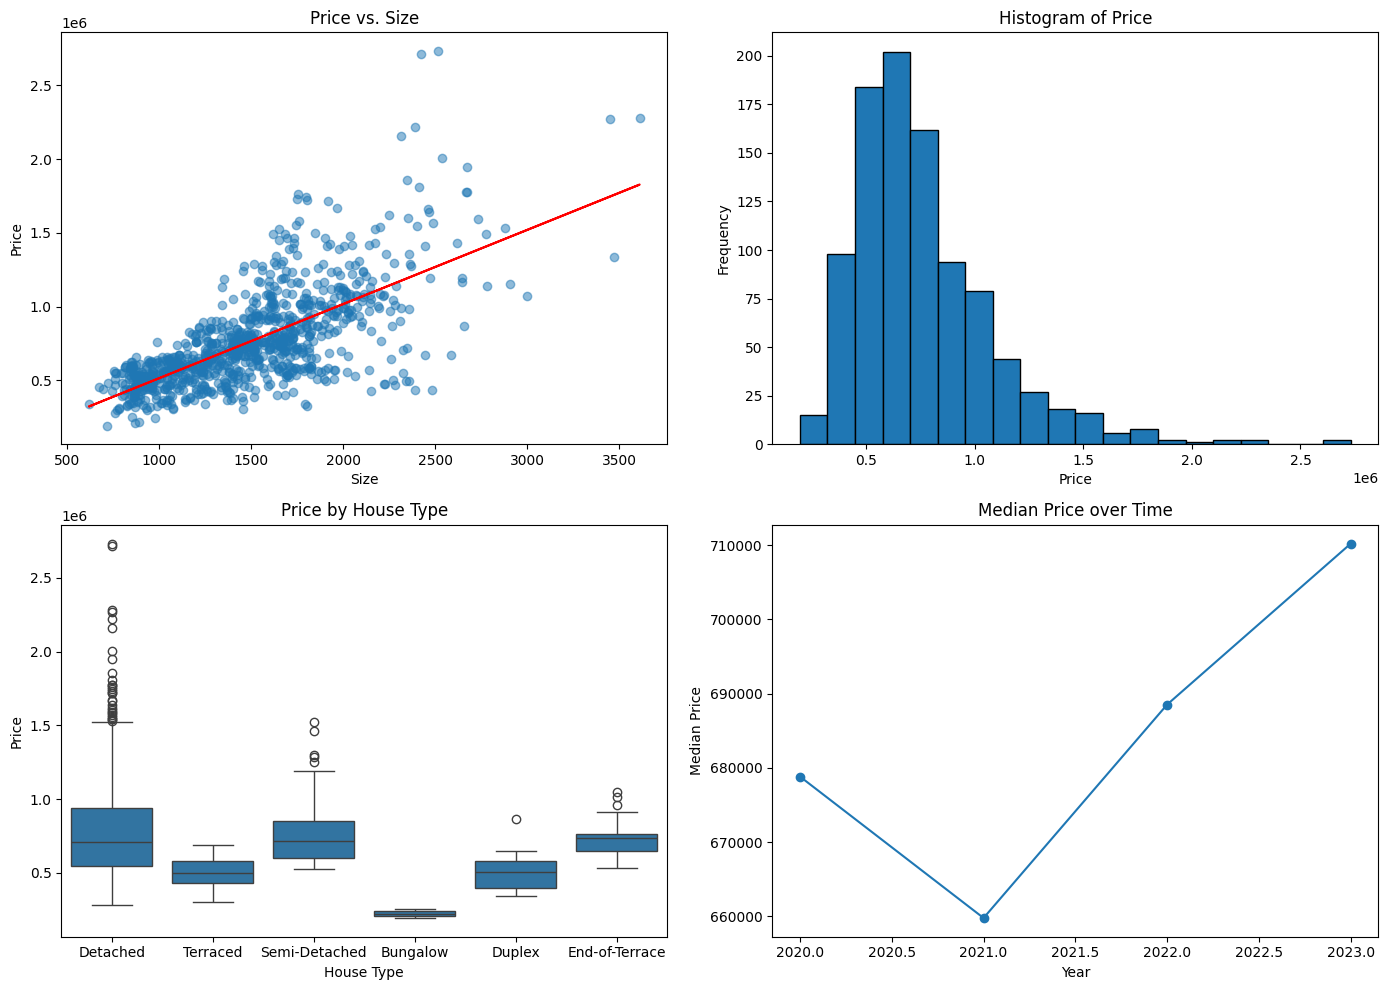

In [117]:
# Figure 1: Basic Matplotlib Graphs
plt.figure(figsize=(14, 10))

# Scatter plot of Price vs. Size
plt.subplot(2, 2, 1)
plt.scatter(houses['Size'], houses['Price'], alpha=0.5)
coefficients = np.polyfit(houses['Size'], houses['Price'], 1)
p = np.poly1d(coefficients)
plt.plot(houses['Size'], p(houses['Size']), color='red', label='Regression line')
plt.title('Price vs. Size')
plt.xlabel('Size')
plt.ylabel('Price')

# Histogram of Price
plt.subplot(2, 2, 2)
plt.hist(houses['Price'], bins=20, edgecolor='black')
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Box plot of Price by House Type
plt.subplot(2, 2, 3)
sns.boxplot(x='House Type', y='Price', data=houses)
plt.title('Price by House Type')

# Line plot of Median Price over Time
plt.subplot(2, 2, 4)
houses['Year'] = houses['Date of Sale'].dt.year
median_prices = houses.groupby('Year')['Price'].median()
plt.plot(median_prices.index, median_prices.values, marker='o')
plt.title('Median Price over Time')
plt.xlabel('Year')
plt.ylabel('Median Price')

plt.tight_layout()
plt.show()

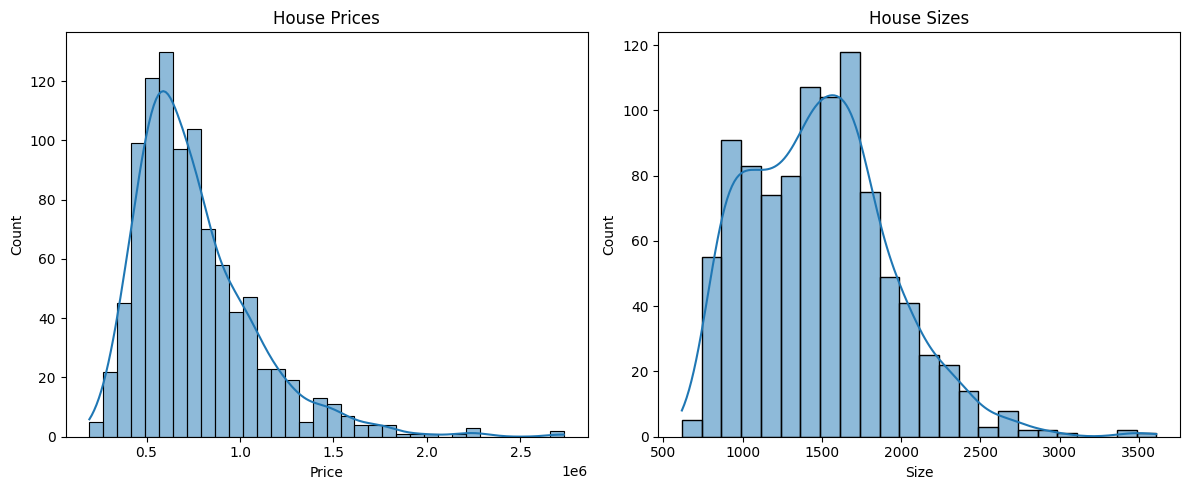

In [47]:
cols = ["Date of Sale", "Location", "Price", "Year Built", "Size", "Bedrooms", "Bathrooms", "House Type", "House Style"]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#Plot house prices using seaborn
sns.histplot(data=houses, x='Price', kde=True, ax=axs[0])
axs[0].set_title('House Prices')

#Plot house Sizes using seaborn
sns.histplot(data=houses, x='Size', kde=True, ax=axs[1])
axs[1].set_title('House Sizes')

plt.tight_layout()
plt.show()

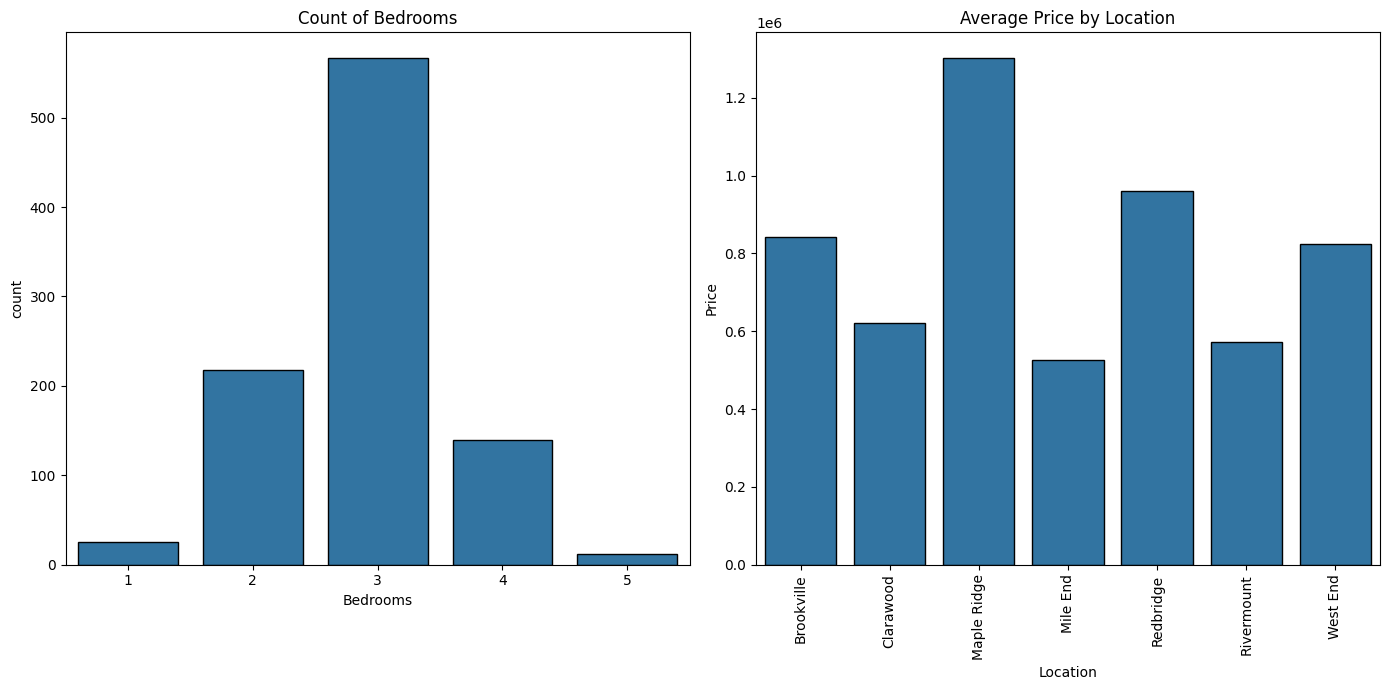

In [26]:
# Figure 3: Basic Seaborn Graphs
plt.figure(figsize=(14, 7))

# Subplot 1: Count plot of Bedrooms
plt.subplot(1, 2, 1)
sns.countplot(x='Bedrooms', data=houses, edgecolor='black')
plt.title('Count of Bedrooms')

# Subplot 2: Bar plot of Average Price by Location
plt.subplot(1, 2, 2)
avg_price_by_location = houses.groupby('Location')['Price'].mean().reset_index()
sns.barplot(x='Location', y='Price', data=avg_price_by_location, edgecolor='black')
plt.title('Average Price by Location')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


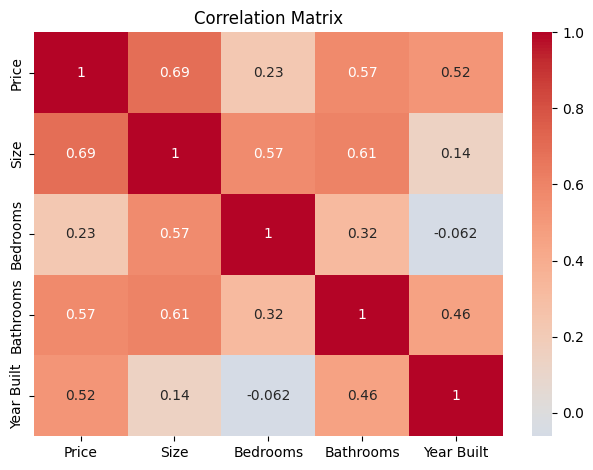

In [27]:
# Plot 3: Heatmap of Correlation Matrix
corr_matrix = houses[['Price', 'Size', 'Bedrooms', 'Bathrooms', 'Year Built']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()

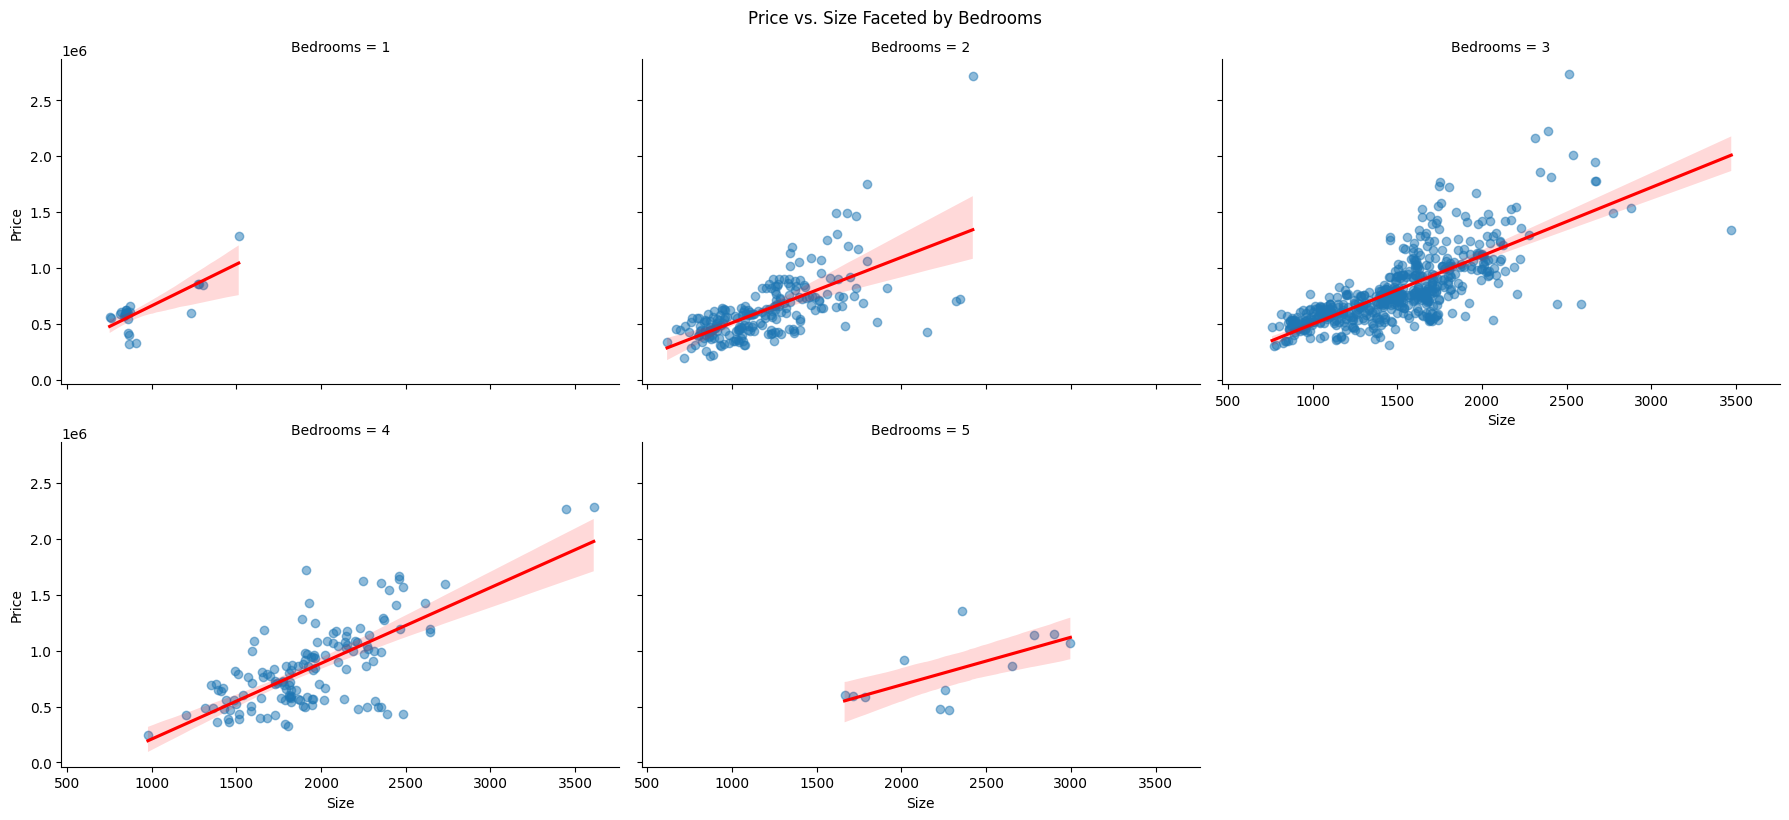

In [28]:
# Figure 2: FacetGrid of Price vs. Size Faceted by Bedrooms
g = sns.FacetGrid(houses, col="Bedrooms", col_wrap=3, height=4, aspect=1.5)
g.map(sns.regplot, "Size", "Price", scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})

g.fig.suptitle('Price vs. Size Faceted by Bedrooms', y=1.02)
plt.show()


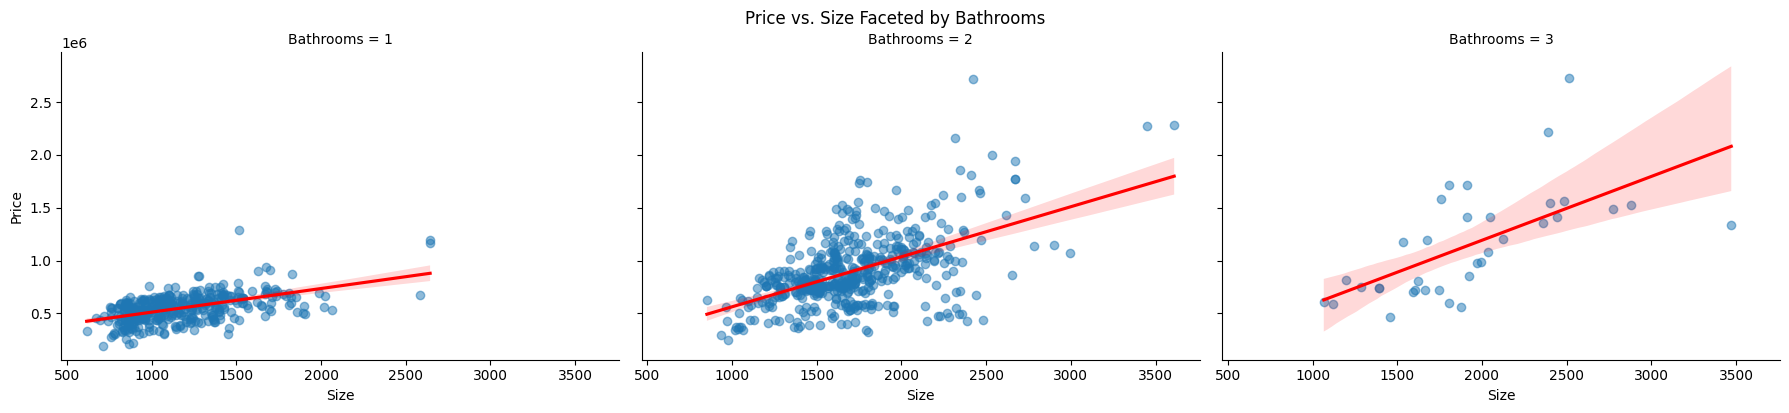

In [29]:
# Figure 3: FacetGrid of Price vs. Size Faceted by Bathrooms
g = sns.FacetGrid(houses, col="Bathrooms", col_wrap=3, height=4, aspect=1.5)
g.map(sns.regplot, "Size", "Price", scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})

g.figure.suptitle('Price vs. Size Faceted by Bathrooms', y=1.02)
plt.show()


## One-Hot Encoding is applied, and Machine Learning models are fitted:

In [108]:
df_encoded = houses.copy()

df_encoded = pd.get_dummies(df_encoded, columns=["Location", "House Type", "House Style"])

boolean_columns = ['Location_Brookville', 'Location_Clarawood', 'Location_Maple Ridge',
       'Location_Mile End', 'Location_Redbridge', 'Location_Rivermount',
       'Location_West End', 'House Type_Bungalow', 'House Type_Detached',
       'House Type_Duplex', 'House Type_End-of-Terrace',
       'House Type_Semi-Detached', 'House Type_Terraced',
       'House Style_1-Storey', 'House Style_2-Storey', 'House Style_Dormer']

df_encoded[boolean_columns] = df_encoded[boolean_columns].astype(int)

df_encoded.head()

X = df_encoded.drop(['Price', 'Date of Sale'], axis=1)
y = df_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



# LINEAR REGRESSION MODEL
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

# Evaluation
rmse_train = mean_squared_error(y_train, y_pred_train)**(1/2)
rmse_test = mean_squared_error(y_test, y_pred_test)**(1/2)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Linear Regression - RMSE Train: {rmse_train}, MSE Test: {rmse_test}")
print(f"Linear Regression - R^2 Train: {r2_train}, R^2 Test: {r2_test}")



Linear Regression - RMSE Train: 146997.88604210972, MSE Test: 135086.0205433168
Linear Regression - R^2 Train: 0.8094199089375137, R^2 Test: 0.7897902959074844


In [103]:
# POLYNOMIAL REGRESSION

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_train_poly, y_train)

# Predictions
y_pred_train_poly = lin_reg_poly.predict(X_train_poly)
y_pred_test_poly = lin_reg_poly.predict(X_test_poly)

# Evaluation
rmse_train_poly = mean_squared_error(y_train, y_pred_train_poly)**(1/2)
rmse_test_poly = mean_squared_error(y_test, y_pred_test_poly)**(1/2)
r2_train_poly = r2_score(y_train, y_pred_train_poly)
r2_test_poly = r2_score(y_test, y_pred_test_poly)

print(f"Polynomial Regression - RMSE Train: {rmse_train_poly}, RMSE Test: {rmse_test_poly}")
print(f"Polynomial Regression - R^2 Train: {r2_train_poly}, R^2 Test: {r2_test_poly}")


Polynomial Regression - RMSE Train: 106265.63570175481, RMSE Test: 1.2350618930499131e+17
Polynomial Regression - R^2 Train: 0.9004041962413427, R^2 Test: -1.757152233086222e+23


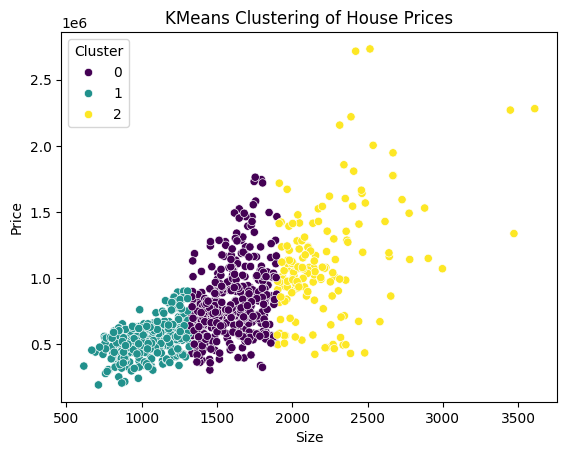

In [104]:
# UNSUPERVISED LEARNING METHOD

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Adding the cluster labels to the dataset
df_encoded['Cluster'] = kmeans.labels_

# Visualize the clusters
sns.scatterplot(x='Size', y='Price', hue='Cluster', data=df_encoded, palette='viridis')
plt.title('KMeans Clustering of House Prices')
plt.show()


In [105]:
# RANDOM FOREST REGRESSOR

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

# Evaluation
rmse_train_rf = mean_squared_error(y_train, y_pred_train_rf)**(1/2)
rmse_test_rf = mean_squared_error(y_test, y_pred_test_rf)**(1/2)
r2_train_rf = r2_score(y_train, y_pred_train_rf)
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print(f"Random Forest - RMSE Train: {rmse_train_rf}, RMSE Test: {rmse_test_rf}")
print(f"Random Forest - R^2 Train: {r2_train_rf}, R^2 Test: {r2_test_rf}")

Random Forest - RMSE Train: 48851.53866566867, RMSE Test: 116535.14695476898
Random Forest - R^2 Train: 0.9789519510109326, R^2 Test: 0.843560722713844


In [ ]:
# HYPER-TUNED RF MODEL

# Further hyperparameter tuning with cross-validation
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf_cv = grid_search.best_estimator_

# Predictions with the best model
y_pred_train_best_rf_cv = best_rf_cv.predict(X_train)
y_pred_test_best_rf_cv = best_rf_cv.predict(X_test)

# Evaluation
rmse_train_best_rf_cv = mean_squared_error(y_train, y_pred_train_best_rf_cv)**(1/2)
rmse_test_best_rf_cv = mean_squared_error(y_test, y_pred_test_best_rf_cv)**(1/2)
r2_train_best_rf_cv = r2_score(y_train, y_pred_train_best_rf_cv)
r2_test_best_rf_cv = r2_score(y_test, y_pred_test_best_rf_cv)

In [106]:
print(f"Best Random Forest Parameters - Min Samples Leaf: {best_rf_cv.min_samples_leaf}, Min Sample Split: {best_rf_cv.min_samples_split}, Number of Estimators: {best_rf_cv.n_estimators}, Max Depth: {best_rf_cv.max_depth} ")
print(f"RMSE Train: {rmse_train_best_rf_cv}, RMSE Test: {rmse_test_best_rf_cv}")
print(f"R^2 Train: {r2_train_best_rf_cv}, R^2 Test: {r2_test_best_rf_cv}")

Best Random Forest Parameters - Min Samples Leaf: 2, Min Sample Split: 2, Number of Estimators: 100, Max Depth: 10 
RMSE Train: 72693.28265482269, RMSE Test: 114628.02360676073
R^2 Train: 0.9533937764882447, R^2 Test: 0.8486391515390518


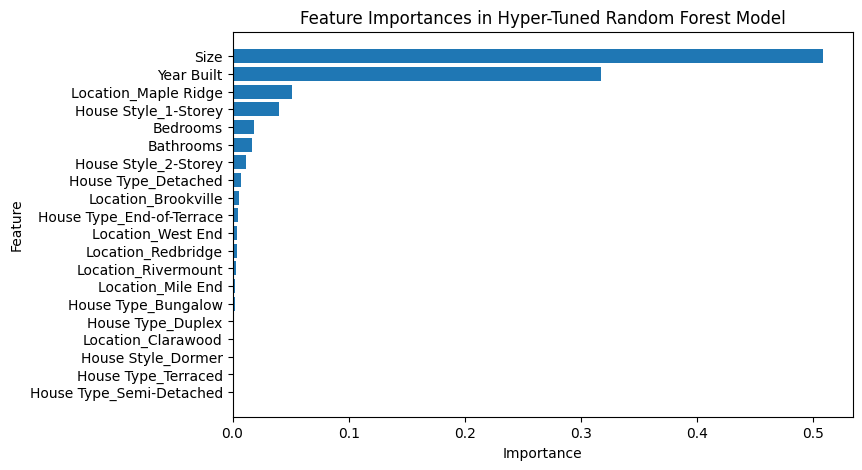

In [116]:
feature_importances = best_rf_cv.feature_importances_
features = X.columns 

# Create df for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Hyper-Tuned Random Forest Model')
plt.gca().invert_yaxis()
plt.show()
